In [1]:
import json
import os
import requests
import torch
from dotenv import load_dotenv
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor

from utils import (
    TorchDataset,
    convert_tensor_to_base64,
    convert_to_base64,
    load_local_vision_dataset,
)

load_dotenv()

True

In [2]:
ENDPOINT = "https://customvision-dev-aoai.openai.azure.com"
DEPLOYMENT_NAME = "gpt4o-003"
URL = f"{ENDPOINT}/openai/deployments/{DEPLOYMENT_NAME}/chat/completions?api-version=2024-02-15-preview"

HEADERS = {'api-key': os.getenv("AZURE_OPENAI_API_KEY"),
           'Content-Type': 'application/json'}

In [36]:
dataset_name = "mppd_ad_metal_plate"

dataset = load_local_vision_dataset(dataset_name=dataset_name,
                                    dataset_config_path="./datasets.json",
                                    root_dir="./",
                                    task_type="object_detection",
                                    )


transform = Compose([ToTensor()])

dataset = TorchDataset(dataset, transform=transform)

print(len(dataset))
sample_img, sample_tgt = dataset[-1]
print(sample_img.shape)
print(sample_tgt)

97
torch.Size([3, 1024, 1024])
tensor([[1.0000, 0.6182, 0.2256, 0.8672, 0.7930]])


In [19]:
sample_img, sample_tgt = dataset[-5]
sample_tgt

tensor([[1.0000, 0.3922, 0.1667, 0.7133, 0.3000]])

In [20]:
tmp = [coord * 1024 for coord in sample_tgt[0]]
tmp

[tensor(1024.),
 tensor(401.6356),
 tensor(170.6667),
 tensor(730.4533),
 tensor(307.2000)]

0.39222222566604614 0.1666666716337204 0.7133333086967468 0.30000001192092896
353.0000030994415 150.00000447034836 288.9999747276306 120.0000062584877


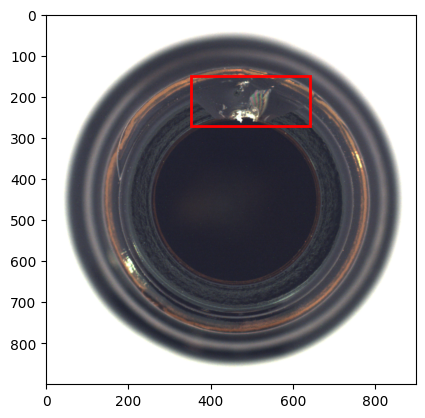

In [22]:
# Sanity check

# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # Convert the tensor image to numpy array
# sample_img_np = sample_img.permute(1, 2, 0).numpy()

# # Create figure and axes
# fig, ax = plt.subplots()

# # Display the image
# ax.imshow(sample_img_np)

# # Extract the bounding box coordinates
# x_top, y_top, x_bottom, y_bottom = sample_tgt[0][1:].tolist()

# print(x_top, y_top, x_bottom, y_bottom)


# # Calculate the width and height of the bounding box
# width = (x_bottom - x_top) * sample_img_np.shape[1]
# height = (y_bottom - y_top) * sample_img_np.shape[0]

# x_top *= sample_img_np.shape[1]
# y_top *= sample_img_np.shape[0]

# print(x_top, y_top, width, height)

# # Create a rectangle patch
# rect = patches.Rectangle((x_top, y_top), width, height, linewidth=2, edgecolor='r', facecolor='none')

# # Add the rectangle patch to the axes
# ax.add_patch(rect)

# # Show the plot
# plt.show()

In [23]:
# # Load prompt 

# with open("prompt_registry.json", "r") as f:
#     prompt_registry = json.load(f)
    
# prompt_registry

In [24]:
# prompt = prompt_registry['3']
# prompt

In [25]:
prompt = """You are an expert visual inspector for a manufacturing company that makes glass bottles. You will be shown a top-view image of a glass bottle and your task is to identify if it is defective or not. Think step-by-step - first identify if there is a defect or not. Second, if there is a defect, identify the type of defect. **IF** present, the defect can only be of the following types: 1.broken 2.contamination. Third, explain your reasoning for the defect if present. Finally, identify where the defect is located in the image and provide the relative coordinates (between 0-1) of the bounding box enclosing the defect in the format [x_top, y_top, x_bottom, y_bottom]. Please return your response **strictly** as a valid JSON object with the following format:
{"is_defective": "<yes or no>",
"reason": "<describe the defect. leave empty if is_defective is no>",
"defect_type": "<type of defect. leave empty if is_defective is no>",
"bounding_box": "[x_top, y_top, x_bottom, y_bottom]. leave empty if is_defective is no"}

Note: If  there is no defect or if you are unsure, please return "is_defective": "no" and leave the other fields empty.
"""

prompt

'You are an expert visual inspector for a manufacturing company that makes glass bottles. You will be shown a top-view image of a glass bottle and your task is to identify if it is defective or not. Think step-by-step - first identify if there is a defect or not. Second, if there is a defect, identify the type of defect. **IF** present, the defect can only be of the following types: 1.broken 2.contamination. Third, explain your reasoning for the defect if present. Finally, identify where the defect is located in the image and provide the relative coordinates (between 0-1) of the bounding box enclosing the defect in the format [x_top, y_top, x_bottom, y_bottom]. Please return your response **strictly** as a valid JSON object with the following format:\n{"is_defective": "<yes or no>",\n"reason": "<describe the defect. leave empty if is_defective is no>",\n"defect_type": "<type of defect. leave empty if is_defective is no>",\n"bounding_box": "[x_top, y_top, x_bottom, y_bottom]. leave empt

In [26]:
# # Save prompt to a registry
# import os

# if os.path.getsize("prompt_registry.json") > 0:
#     with open("prompt_registry.json", "r") as f:
#         prompt_registry = json.load(f)
#         last_idx = max(map(int, prompt_registry.keys()))
#         prompt_registry[last_idx + 1] = prompt
# else:
#     prompt_registry = {}
#     prompt_registry[0] = prompt
    
# # Save the updated prompt registry
# with open("prompt_registry.json", "w") as f:
#     json.dump(prompt_registry, f)
    

In [27]:
def get_request_body(prompt, base64_image):
    request_body = {
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant."
            },
            {
                "role": "user",
                "content": [
                        {
                            "type": "text",
                            "text": f"{prompt}"
                        },
                    {
                            "type": "image_url",
                            "image_url": {
                                "url": "data:image/png;base64," + f"{base64_image}",
                            }
                            }
                ]
            }
        ],
        "max_tokens": 300
    }

    return request_body


# Sanity check
# prompt = "What is this object?"
# base64_image = convert_tensor_to_base64(sample_img)
# request_body = get_request_body(prompt, base64_image)
# print(request_body)

In [28]:
import time

responses = []

for sample_idx in range(len(dataset)):
    print(f"Processing sample {sample_idx}...")
    
    sample_img, sample_tgt = dataset[sample_idx]
    base64_image = convert_tensor_to_base64(sample_img)

    request_body = get_request_body(prompt, base64_image)

    response = requests.post(URL, headers=HEADERS,
                             json=request_body, timeout=120)
    
    
    responses.append({"sample_idx": sample_idx,
                    "response": response.json()["choices"][0]["message"]["content"],
                    "target": sample_tgt.tolist()})
    
    # Wait for 20 seconds
    time.sleep(15)
    

# responses

Processing sample 0...
Processing sample 1...
Processing sample 2...
Processing sample 3...
Processing sample 4...
Processing sample 5...
Processing sample 6...
Processing sample 7...
Processing sample 8...
Processing sample 9...
Processing sample 10...
Processing sample 11...
Processing sample 12...
Processing sample 13...
Processing sample 14...
Processing sample 15...
Processing sample 16...
Processing sample 17...
Processing sample 18...
Processing sample 19...
Processing sample 20...
Processing sample 21...
Processing sample 22...
Processing sample 23...
Processing sample 24...
Processing sample 25...
Processing sample 26...
Processing sample 27...
Processing sample 28...
Processing sample 29...
Processing sample 30...
Processing sample 31...
Processing sample 32...
Processing sample 33...
Processing sample 34...
Processing sample 35...
Processing sample 36...
Processing sample 37...
Processing sample 38...
Processing sample 39...
Processing sample 40...
Processing sample 41...
Pr

In [29]:
def extract_valid_json(response):
    try:
        response = json.loads(response)
        return response
    except:
        if response.startswith("```json\n"):
            response = response.replace("```json\n", "")
            response = response.replace("\n```", "")
            response = json.loads(response)
            return response
        else:
            return "Invalid JSON"
        
# Sanity check
# sample_response = responses[0]["response"]
# print(extract_valid_json(sample_response))
            

In [30]:
for response in responses:
    response["parsed_response"] = extract_valid_json(response["response"])
    if response["parsed_response"] == "Invalid JSON":
        print(response["response"])
        print(response["parsed_response"])
        print(response["sample_idx"])
        print(response["target"])
        print("\n")
    
    

In [31]:
responses

[{'sample_idx': 0,
  'response': '```json\n{\n  "is_defective": "yes",\n  "reason": "The bottle has contamination on its inside surface.",\n  "defect_type": "contamination",\n  "bounding_box": "[0.0, 0.2, 0.2, 0.5]"\n}\n```',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]],
  'parsed_response': {'is_defective': 'yes',
   'reason': 'The bottle has contamination on its inside surface.',
   'defect_type': 'contamination',
   'bounding_box': '[0.0, 0.2, 0.2, 0.5]'}},
 {'sample_idx': 1,
  'response': '```json\n{\n  "is_defective": "no",\n  "reason": "",\n  "defect_type": "",\n  "bounding_box": ""\n}\n```',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]],
  'parsed_response': {'is_defective': 'no',
   'reason': '',
   'defect_type': '',
   'bounding_box': ''}},
 {'sample_idx': 2,
  'response': '{\n    "is_defective": "no",\n    "reason": "",\n    "defect_type": "",\n    "bounding_box": ""\n}',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]],
  'parsed_response': {'is_defective': 'no',
   'reason': '',
 

In [32]:
def calculate_accuracy(responses):
    correct = 0
    for item in responses:
        response = item["parsed_response"]
        target = item["target"][0]
        
        if target == 0 and response["is_defective"] == "no":
            pass
            # correct += 1
        elif target != 0 and response["is_defective"] == "yes":
            correct += 1
            
    return correct / len(responses)


calculate_accuracy(responses)

0.891566265060241

In [33]:
# Save responses

with open(f"{dataset_name}_responses.json", "w") as f:
    json.dump(responses, f)

In [221]:
### One off evaluation

In [36]:
sample_img, sample_tgt = dataset[-5]
print(sample_tgt)

base64_image = convert_tensor_to_base64(sample_img)

request_body = get_request_body(prompt, base64_image)

response = requests.post(URL, headers=HEADERS,
                             json=request_body, timeout=120)


tensor([[4.0000, 0.3223, 0.3652, 0.5791, 0.5254],
        [4.0000, 0.6201, 0.4219, 0.7051, 0.5459]])


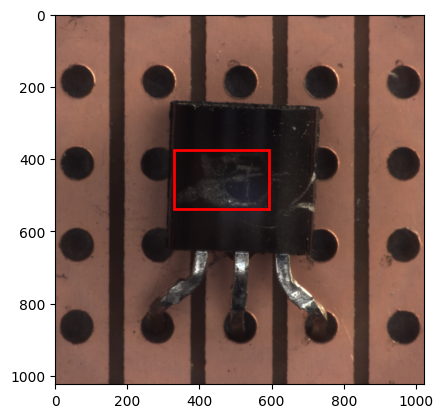

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the tensor image to numpy array
sample_img_np = sample_img.permute(1, 2, 0).numpy()

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(sample_img_np)

# Extract the bounding box coordinates
x_top, y_top, x_bottom, y_bottom = sample_tgt[0][1:].tolist()

# Calculate the width and height of the bounding box
width = (x_bottom - x_top) * sample_img_np.shape[1]
height = (y_bottom - y_top) * sample_img_np.shape[0]

x_top *= sample_img_np.shape[1]
y_top *= sample_img_np.shape[0]

# Create a rectangle patch
rect = patches.Rectangle((x_top, y_top), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle patch to the axes
ax.add_patch(rect)

# Show the plot
plt.show()

In [38]:
response.json()

{'choices': [{'content_filter_results': {'hate': {'filtered': False,
     'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': '```json\n{\n    "is_defective": "yes",\n    "reason": "The transistor has a damaged casing.",\n    "defect_type": "damaged casing",\n    "bounding_box": "[0.2, 0.2, 0.8, 0.6]"\n}\n```',
    'role': 'assistant'}}],
 'created': 1720558826,
 'id': 'chatcmpl-9jCEkINi1DpckQ6c1xA3FtbJxqNrW',
 'model': 'gpt-4o-2024-05-13',
 'object': 'chat.completion',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_result': {'jailbreak': {'filtered': False,
     'detected': False},
    'custom_blocklists': {'filtered': False, 'details': []}}},
  {'prompt_index': 1,
   'content_filter_result': {'sexual': {'filtered': False, 'severity': 'safe